In [334]:
#Load Data
import pandas as pd
from pandas import DataFrame
import math
import datetime

data= pd.read_csv('/Users/jackhulbert/Desktop/Data Science Projects/CLV/Data/data-2.csv')
data['CustomerID'] = data['CustomerID'].astype(str)
data.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [335]:
#Group + Clean Data for LTV Modeling
df= data.groupby(["InvoiceNo","InvoiceDate","CustomerID"]).sum([('UnitPrice'),('Quantity')]).reset_index()
for row in df:
    df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate']).dt.date
    df['OrderValue'] = df['UnitPrice'] * df['Quantity']
    df[(df['Quantity']>0)]
    df[(df['OrderValue']>0)]
    df[pd.notnull(df['CustomerID'])]

df.head()

,InvoiceNo,InvoiceDate,CustomerID,Quantity,UnitPrice,OrderValue
0,536365,2010-12-01,17850.0,40,27.37,1094.80
1,536366,2010-12-01,17850.0,12,3.70,44.40
2,536367,2010-12-01,13047.0,83,58.24,4833.92
3,536368,2010-12-01,13047.0,15,19.10,286.50
4,536369,2010-12-01,13047.0,3,5.95,17.85


In [194]:
#import libraries
from datetime import datetime, timedelta,date
import pandas as pd
%matplotlib inline
from sklearn.metrics import classification_report,confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from __future__ import division
from sklearn.cluster import KMeans
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from scipy.optimize import minimize
from lifetimes.utils import summary_data_from_transaction_data
from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter
import lifetimes



In [336]:
#Reduce Dataframe for model

df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'],format='%m/%d/%y', errors='ignore')

df=clv[['CustomerID','InvoiceDate','OrderValue']]

#maxdate
maxdate=df['InvoiceDate'].max()
calibration_period_end= maxdate 


In [296]:
#CUSTOMER METRICS
import lifetimes

# set the last transaction date as the end point for this historical dataset
current_date = df['InvoiceDate'].max()

# calculate the required customer metrics
metrics = (
  lifetimes.utils.summary_data_from_transaction_data(
    df,
    customer_id_col='CustomerID',
    datetime_col='InvoiceDate',
    monetary_value_col='OrderValue',
    observation_period_end = current_date, 
    freq='D'
    )
  )
metrics.describe()

,frequency,recency,T,monetary_value
count,4335.000000,4335.000000,4335.000000,4.335000e+03
mean,2.895732,130.640600,222.795848,1.445640e+04
std,7.167790,132.244598,117.809842,6.987961e+04
min,0.000000,0.000000,0.000000,0.000000e+00
25%,0.000000,0.000000,112.000000,0.000000e+00
50%,1.000000,92.000000,248.000000,2.963545e+03
75%,3.000000,252.000000,326.000000,1.242754e+04
max,272.000000,373.000000,373.000000,3.046728e+06


In [297]:
#SPLIT INTO HOLDOUT AND CALIBRATION PERIOD

# set the last transaction date as the end point for this historical dataset
current_date = df['InvoiceDate'].max()

# define end of calibration period
holdout_days = 90
calibration_end_date = current_date - timedelta(days = holdout_days)

# calculate the required customer metrics
metrics_cal = (
  lifetimes.utils.calibration_and_holdout_data(
    df,
    customer_id_col='CustomerID',
    datetime_col='InvoiceDate',
    observation_period_end = current_date,
    calibration_period_end=calibration_end_date,
    freq='D'    
    ))

In [298]:
metrics_cal.head()

,frequency_cal,recency_cal,T_cal,frequency_holdout,duration_holdout
CustomerID,,,,,
12347.0,4.0,238.0,277.0,2.0,90.0
12348.0,2.0,110.0,268.0,1.0,90.0
12350.0,0.0,0.0,220.0,0.0,90.0
12352.0,3.0,34.0,206.0,3.0,90.0
12353.0,0.0,0.0,114.0,0.0,90.0


In [310]:
#remove repeat buyers
filtered = metrics[metrics['frequency'] > 0]
filtered_cal = metrics_cal[metrics_cal['frequency_cal'] > 0]


In [337]:
from lifetimes.fitters.pareto_nbd_fitter import ParetoNBDFitter
from lifetimes.fitters.beta_geo_fitter import BetaGeoFitter

input = filtered_cal

# fit a model
model = ParetoNBDFitter(penalizer_coef=0)
model.fit( input['frequency_cal'], input['recency_cal'], input['T_cal'])

<lifetimes.ParetoNBDFitter: fitted with 1944 subjects, alpha: 104.87, beta: 1093.71, r: 1.87, s: 0.00>

In [338]:
# get predicted frequency during holdout period
frequency_holdout_predicted = model.predict( input['duration_holdout'], input['frequency_cal'], input['recency_cal'], input['T_cal'])

# get actual frequency during holdout period
frequency_holdout_actual = input['frequency_holdout']

In [339]:
# get actual frequency during holdout period
frequency_holdout_actual = input['frequency_holdout']
print(frequency_holdout_actual)

CustomerID
12347.0     2.0
12348.0     1.0
12352.0     3.0
12356.0     1.0
12359.0     1.0
           ... 
18263.0     1.0
18272.0     2.0
18273.0     1.0
18283.0     5.0
nan        72.0
Name: frequency_holdout, Length: 1944, dtype: float64


In [340]:
#Calculate MSE

def score_model(actuals, predicted, metric='mse'):
  # make sure metric name is lower case
  metric = metric.lower()
  
  # Mean Squared Error and Root Mean Squared Error
  if metric=='mse' or metric=='rmse':
    val = np.sum(np.square(actuals-predicted))/actuals.shape[0]
    if metric=='rmse':
        val = np.sqrt(val)
  
  # Mean Absolute Error
  elif metric=='mae':
    np.sum(np.abs(actuals-predicted))/actuals.shape[0]
  
  else:
    val = None
  
  return val

# score the model
print('MSE: {0}'.format(score_model(frequency_holdout_actual, frequency_holdout_predicted, 'mse')))

MSE: 3.7972937463851624


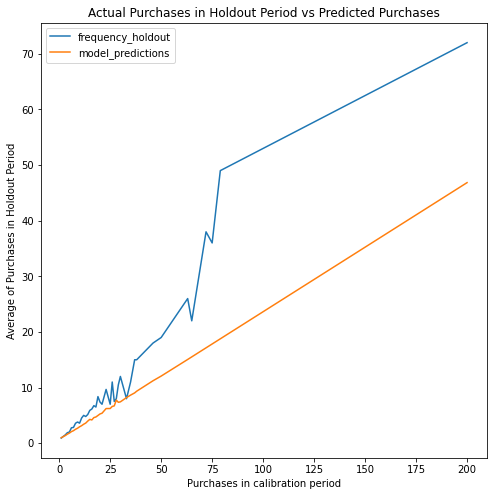

In [341]:
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases

plot_calibration_purchases_vs_holdout_purchases(
  model, 
  input, 
  n=90, 
  **{'figsize':(8,8)}
  )

display()
#The model appears to have trouble predicting for customers who have 75 or more orders in the eval period. This is a rather small cohort of customers by our datasets standard.

In [342]:
#Calculate probability alive and # of purchases in time period X

metrics['prob_alive']=model.conditional_probability_alive(
    metrics['frequency'], 
    metrics['recency'], 
    metrics['T']
    )

#30 day prediction
metrics['purchases_next30days']=(
  model.conditional_expected_number_of_purchases_up_to_time(
    30, 
    metrics['frequency'], 
    metrics['recency'], 
    metrics['T']
    )
  )

#90 day prediction
metrics['purchases_next90days']=(
  model.conditional_expected_number_of_purchases_up_to_time(
    90, 
    metrics['frequency'], 
    metrics['recency'], 
    metrics['T']
    )
  )

metrics.tail(10)

,frequency,recency,T,monetary_value,conditional avg profit,clv,rank,decile,prob_alive,purchases_next30days,purchases_next90days
CustomerID,,,,,,,,,,,
18274.0,0.0,0.0,30.0,0.000000e+00,2.598937e+04,0.000000e+00,1553.0,3,1.0,0.416449,1.249348
18276.0,0.0,0.0,43.0,0.000000e+00,2.598937e+04,0.000000e+00,1554.0,3,1.0,0.379837,1.139510
18277.0,0.0,0.0,58.0,0.000000e+00,2.598937e+04,0.000000e+00,1555.0,3,1.0,0.344854,1.034563
18278.0,0.0,0.0,73.0,0.000000e+00,2.598937e+04,0.000000e+00,1556.0,3,1.0,0.315772,0.947317
18280.0,0.0,0.0,277.0,0.000000e+00,2.598937e+04,0.000000e+00,1557.0,3,1.0,0.147082,0.441246
18281.0,0.0,0.0,180.0,0.000000e+00,2.598937e+04,0.000000e+00,1558.0,3,1.0,0.197165,0.591494
18282.0,1.0,119.0,126.0,6.585600e+02,1.352840e+04,6.585600e+02,1729.0,3,1.0,0.373225,1.119675
18283.0,13.0,334.0,337.0,9.626459e+03,1.083077e+04,1.251440e+05,3883.0,8,1.0,1.009725,3.029175
18287.0,2.0,159.0,201.0,2.272572e+04,2.383714e+04,4.545144e+04,3324.0,7,1.0,0.379790,1.139371


In [330]:
#Gamma Gamma prediction for conditional avg profit

returning_customers_summary = metrics[(metrics['frequency']>0) & (metrics['monetary_value'])>0]
print(returning_customers_summary.head())
print(len(returning_customers_summary))

from lifetimes import GammaGammaFitter
ggf = GammaGammaFitter(penalizer_coef = 0)
ggf.fit(returning_customers_summary['frequency'],
        returning_customers_summary['monetary_value'])

metrics['conditional avg profit']=(ggf.conditional_expected_average_profit(
        metrics['frequency'],
        metrics['monetary_value']))


metrics['clv'] = metrics['monetary_value']*metrics['frequency']

metrics['rank'] = metrics['clv'].rank(method='first')
metrics['decile'] = pd.qcut(metrics['rank'].values, 10,duplicates='drop').codes
metrics.to_csv('clv_output.csv')

            frequency  recency      T  monetary_value  conditional avg profit  \
CustomerID                                                                      
12347.0           6.0    365.0  367.0    27796.676667            27531.261993   
12348.0           3.0    283.0  358.0    15489.303333            18178.392095   
12352.0           6.0    260.0  296.0     5822.086667             8783.776082   
12356.0           2.0    303.0  325.0     9492.400000            15110.375172   
12358.0           1.0    149.0  150.0     9557.840000            17906.214508   

                  clv    rank  decile  prob_alive  purchases_next30days  \
CustomerID                                                                
12347.0     166780.06  3986.0       9         1.0              0.498686   
12348.0      46467.91  3338.0       7         1.0              0.299330   
12352.0      34932.52  3163.0       7         1.0              0.595177   
12356.0      18984.80  2797.0       6         1.0        